In [1]:
# A cell to run functions directly.
using Reexport
using Distributions
using Statistics
using GeoStats
using Random
using DataFrames
import GLMakie as Mke
using Infiltrator
using AbstractGPs
using Unitful
using Plots
using DataStructures
using POMDPs
include("../src/config.jl");
include("../src/pomdp.jl")
pomdp = CCSPOMDP();

FEATURE = :topSealThickness


:topSealThickness

In [2]:
visualize_gt(pomdp, 2)

### Test: Action function returns all actions

In [3]:
all_actions = POMDPs.actions(pomdp);

### Test: Observation function returns correct distributions

  2.813991 seconds (31.21 M allocations: 1.489 GiB, 15.85% gc time, 41.59% compilation time)
Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}}, Distributions.Continuous, Float64}
Reward: -1.332918653949492e12


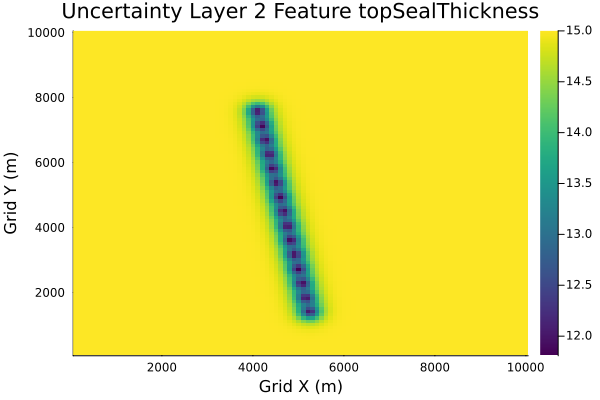

In [4]:
# Taking a seismic line action first
distr = POMDPs.observation(pomdp, all_actions[21], pomdp.state)
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[21])
println(typeof(distr), "\nReward: ", reward)

visualize_uncertainty(pomdp, 2, FEATURE)

In [5]:
pomdp.rocktype_belief

5-element Vector{Distributions.Categorical{Float64, Vector{Float64}}}:
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])

In [6]:
distr = POMDPs.observation(pomdp, all_actions[2], pomdp.state);
pomdp.rocktype_belief

5-element Vector{Distributions.Categorical{Float64, Vector{Float64}}}:
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 1.0, 0.0])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 1.0, 0.0])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 0.0, 1.0])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 1.0, 0.0])
 Distributions.Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p=[0.0, 0.0, 1.0])

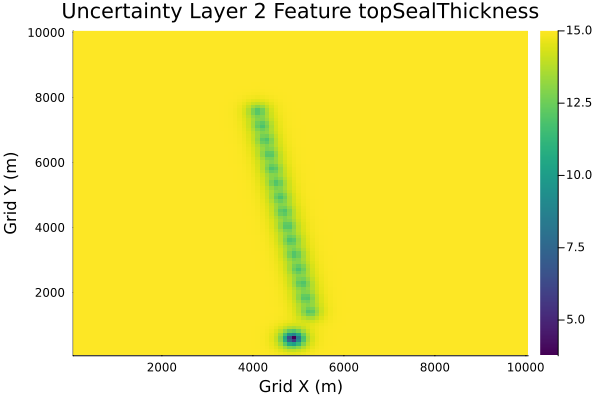

In [7]:
visualize_uncertainty(pomdp, 2, FEATURE)

  0.565775 seconds (10.06 M allocations: 549.352 MiB, 11.27% gc time, 5.69% compilation time)
Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}}, Distributions.Continuous, Float64}
Reward: 3.5004084015723877e9


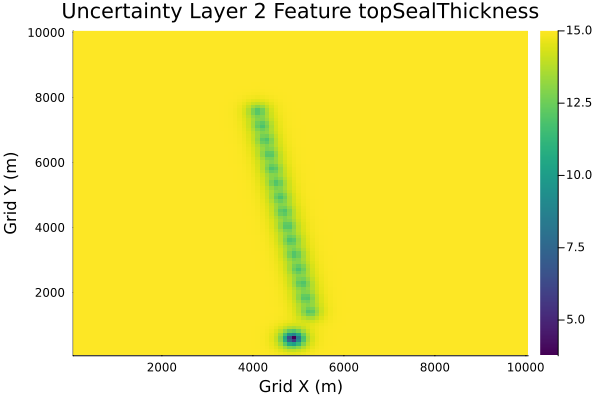

In [8]:
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[2])
println(typeof(distr), "\nReward: ", reward)

visualize_uncertainty(pomdp, 2, FEATURE)

  0.936763 seconds (18.92 M allocations: 908.546 MiB, 6.28% gc time)
Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}}, Distributions.Continuous, Float64}
Reward: 3.925639584619281e10


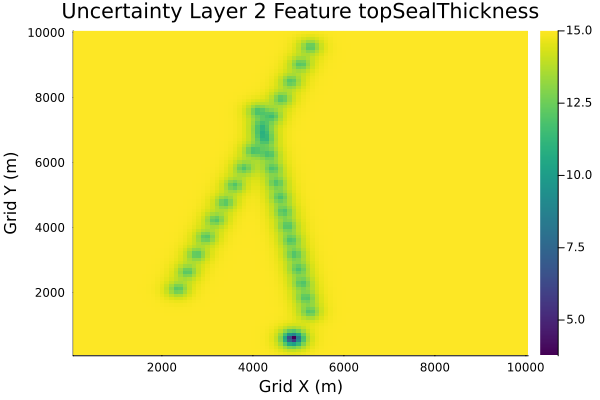

In [9]:
# Timing test for seismic line observation and reward function
distr = POMDPs.observation(pomdp, all_actions[19], pomdp.state)
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[19])
println(typeof(distr), "\nReward: ", reward)
visualize_uncertainty(pomdp, 2, FEATURE)

  1.032986 seconds (19.82 M allocations: 945.167 MiB, 6.47% gc time)
Distributions.ProductDistribution{2, 1, Vector{MixtureModel{Multivariate, Distributions.Continuous, MvNormal, Distributions.Categorical{Float64, Vector{Float64}}}}, Distributions.Continuous, Float64}
Reward: 4.4629012583063965e9


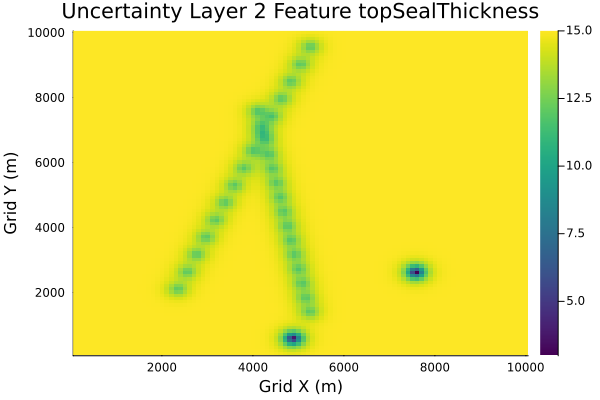

In [10]:
# Timing test for well log observation and reward function
distr = POMDPs.observation(pomdp, all_actions[1], pomdp.state)
reward = POMDPs.reward(pomdp, pomdp.state, all_actions[1])
println(typeof(distr), "\nReward: ", reward)
visualize_uncertainty(pomdp, 2, FEATURE)